<img src="resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Workshop SWDB 2024 </h1> 
<h3 align="center">Day 3 2024 - Neuron Morphology</h3> 
<h3 align="center">Notebook 1: Analyzing Brain Connectivity via Projections of Light Microscopy Neurons</h3> 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
This cell sets up a variable called `data_root` that you should use in any code below to access the dataset in question
</div>

In [1]:
import platform
platstring = platform.platform()

if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2024/anatomy/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/anatomy/"
elif ('amzn2' in platstring):
    # then on AWS
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2024/anatomy/"

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
# Section 1: Introduction

<font size="4"> The main objective of this notebook is to analyze the whole-brain connectivity of neurons imaged via Light Microscopy (LM). The neurons in this dataset are acquired by imaging the volume of an entire brain wherein a small number of cells are sparsely labelled, and then tracing the axons and dendrites of those cells to reconstruct their full morphologies. Neurons from several brains are integrated by aligning each sample to the Common Coordinate Framework (CCF: see databook). 
    
<font size="4"> Whereas Electron Microscopy (EM) densely reconstructs neuronal morphologies contained within a small volume of tissue, this LM dataset contains the brain-wde morphologies of sparsely sampled neurons (see Figure 1). LM neurons allow us to investigate how different brain regions communicate by analyzing the neurons or "output channels" by which information flows across the brain. However, unlike EM, this dataset does not show the specific connections between individual neurons. As with many aspects of neuroscience, there is a tradeoff between scale and resolution, and which dataset is best suited for your analysis often depends upon the scientific questions you're seeking to address.


<div style="text-align: center;">
    <img src='imgs/lm-vs-em.png' style="max-width: 65%; height: auto;">
</div>

<font size="4"><b> Figure 1:</b> LM neuron shown in blue and EM neuron shown in purple.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<font size="4"> As an introduction to analyzing projections of LM neurons, we will explore three open-ended questions related to brain connectivity:

<font size="4"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <strong>Question 1:</strong> What do the inputs to a particular brain region look like? </font>

<font size="4"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <strong>Question 2:</strong>  Where else do those inputs send their collaterals?  </font>
    
<font size="4"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <strong>Question 3:</strong> Are neuronal morphologies stereotyped, or are there distinct projection classes?

<font size="4"> These questions involve analyzing sets of neuronal morphologies to provide a general overview of how neurons connect different brain regions. Neurons integrate inputs at their somas and dendrites, then transmit their outputs via axons. In this tutorial, we'll define connectivity by the presence and number of axon terminals (also referred to as axonal endpoints). We'll refer to hypothetical brain region A being connected to region B if a neuron exists with somatic or dendritic compartments in A, and axon terminals in B. We'll address Question 1 by querying neurons with axon terminals in the mediodorsal nucleus of the thalamus (MD). Note that while each neuron in the LM dataset has been fully reconstructed, by no means does this dataset contain a comprehensive accounting of all neurons in all brain areas. Keep this in mind when formulating your future analyses - failing to observe a connection may reflect a lack of sampling rather than a true lack of connectivity. 
    
<font size="4"> Some neurons are quite focal in their projections (this is true of many neurons from primary thalamic nuclei), while others diffusely target several brain regions (this is often true of neurons in higher order thalamic nuclei). We'll follow up on Q1 by more closely examining several of the inputs to MD, and seeing where else their axon terminals ramify. This tells us about how information flows through the brain and which areas are receiving shared inputs.
    
<font size="4"> In Q1 and Q2 we'll look at the inputs to MD, but in Question 3 we'll turn to looking at the outputs of that nucleus. We'll use clustering approaches to ask: how many distinct output channels are there from MD? Some nuclei are monolithic and have very stereotyped patterns of connectivity, whereas other brain regions display discrete or continous variability in their projection targets. In addressing Questions 1 - 3, we'll learn something about the input and output structure of a multi-regional circuit, and in so doing learn skills that can be translated to future analyses in your group projects.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<font size="4"> **Brain Region Information:** Neuron morphologies are described by sequences of points or vertices. Every LM neuron within this dataset has been registered to the CCF, so each point will contain metadata describing the region of the brain that point lies within. This metadata is saved as a numerical identifier of that brain region, called a CCF id. We use a python package called "brainglobe_atlasapi" to query information from the CCF ontology (an ontology is a map of the hierarchical relationship between different brain regions). This allows us to go between a CCF region's numerical identifier and other properties such as its full name, acronym, or children / parent regions. We can extract information about a brain region in the CCF atlas by using a routine called "get_ccf_property". This routine takes a CCF id and some property (e.g. name or acronym) as the inputs, then returns the corresponding information about that CCF id. Next, we'll provide some examples of using this routine.


<div style="text-align: center;">
    <img src='imgs/ccf.png' style="max-width: 65%; height: auto;">
</div>

<font size="4"><b> Figure 2:</b> Sagittal view of Allen Reference Atlas.

In [2]:
from brainglobe_atlasapi import BrainGlobeAtlas
from pprint import pprint
from utils.ccf_utils import get_ccf_property

import brainglobe_atlasapi as atlasapi
from brainglobe_atlasapi import config
import os
config.write_default_config()

# Load ccf atlas
brain_globe_path = os.path.join(data_root, ".brainglobe")
atlasapi.config.write_config_value('brainglobe_dir', brain_globe_path)
ccf_atlas = BrainGlobeAtlas('allen_mouse_10um')

# Print important data structures in "ccf_atlas"
print("This is a look up table which stores basic information about each structure...\n")
print(ccf_atlas.lookup_df)


# To see the hierarchical structure of the ccf, uncomment the lines below
#print("\n This is the hierarchy of regions stored in the ccf")
#print(ccf_atlas.structures)


This is a look up table which stores basic information about each structure...

    acronym   id                                name
0      root  997                                root
1      grey    8       Basic cell groups and regions
2        CH  567                            Cerebrum
3       CTX  688                     Cerebral cortex
4     CTXpl  695                      Cortical plate
..      ...  ...                                 ...
835      V3  129                     third ventricle
836      AQ  140                   cerebral aqueduct
837      V4  145                    fourth ventricle
838     V4r  153                      lateral recess
839       c  164  central canal, spinal cord/medulla

[840 rows x 3 columns]


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


<font size="4"> We can extract information about a given region in the ccf by querying from "ccf_atlas.structures". </font>
    

In [3]:
# Report brain region
ccf_id = 1062
pprint(ccf_atlas.structures[ccf_id])


# Querying information with "get_ccf_property"
ccf_id = 1062
ccf_name = get_ccf_property(ccf_atlas, ccf_id, "name")
ccf_acronym = get_ccf_property(ccf_atlas, ccf_id, "acronym")

print(f"\nThe ccf_id '{ccf_id}' represents the '{ccf_name}'")
print(f"The '{ccf_name}' are abbreviated as '{ccf_acronym}'")


{'acronym': 'SSp-bfd6b',
 'id': 1062,
 'mesh': None,
 'mesh_filename': PosixPath('/data/.brainglobe/allen_mouse_10um_v1.2/meshes/1062.obj'),
 'name': 'Primary somatosensory area, barrel field, layer 6b',
 'rgb_triplet': [24, 128, 100],
 'structure_id_path': [997, 8, 567, 688, 695, 315, 453, 322, 329, 1062]}

The ccf_id '1062' represents the 'Primary somatosensory area, barrel field, layer 6b'
The 'Primary somatosensory area, barrel field, layer 6b' are abbreviated as 'SSp-bfd6b'


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
    
<font size="4"> This function also has an optional argument called "depth" that traverses the region hierarchy to return the name of the region name for the given depth. Note that this ontology is not always intuitive, as different brain structures have different maximal depths. We'll stick to the maximal depth (the default setting of get_ccf_property) for most, but not all, of this tutorial. </font>

In [4]:
# Report hierarchy
depth = 7
ccf_name = get_ccf_property(ccf_atlas,ccf_id, "name", depth=depth)
ccf_acronym = get_ccf_property(ccf_atlas, ccf_id, "acronym", depth=depth)

print(f"The ccf_id '{ccf_id}' represents the '{ccf_name}'")
print(f"The '{ccf_name}' are abbreviated as '{ccf_acronym}'")


The ccf_id '1062' represents the 'Primary somatosensory area'
The 'Primary somatosensory area' are abbreviated as 'SSp'


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
# Section 2: Analyzing the Inputs to a Brain Region
    
<font size="4"> We'll start by loading all of the neurons currently available to us within the LM datasets. </font>

<h3> Imports </h3>

In [5]:
from utils.ccf_utils import get_ccf_ids
from utils.skeleton_loading_utils import number_of_samples, load_lm_datasets, progress_bar

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skeleton_plot as skelplot
import seaborn as sns

%matplotlib inline


<h3> Load Dataset </h3>

In [6]:
skel_list = load_lm_datasets(data_root)

Loading datasets...
exaSPIM_609281_2022-11-03_13-49-18_reconstructions/precomputed:  [==================================================] 25/25
exaSPIM_651324_2023-03-06_15-13-25_reconstructions/precomputed:  [==================================================] 18/18
exaSPIM_653158_2023-06-01_20-41-38_reconstructions/precomputed:  [==================================================] 42/42
exaSPIM_653980_2023-08-10_20-08-29_reconstructions/precomputed:  [==================================================] 20/20
mouselight_reconstructions/precomputed:  [==================================================] 1549/1549


In [7]:
# How many total neurons are contained within these datasets?
len(skel_list)

1654

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Inputs/Outputs of a Single Neuron

<font size="4"> Our journey to understand how the brain is connected begins with analyzing how a single neuron connects different regions. The purpose of this elementary analysis is to introduce a set of routines that simplify querying information such as finding all neurons with somas in a certain CCF region. We'll begin by choosing a skeleton from our dataset and performing the following query:
        
<font size="4"><strong> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Query 1:</strong> Which brain regions do the dendritic or axonal endpoints of a given neuron reside in? </font>

<font size="4"> Each skeleton has a node-level attribute called "id" that specifies where a node is located in CCF space. We will use subroutine called "get_ccf_ids" which is stored in "ccf_utils.py". The purpose of this routine is to easily extract the CCF ids from vertices within a certain compartment (e.g. axons or dendrites) and/or vertices which are end points or branch points, see documentation for more details. Next, let's look at some simple examples of using the routine "get_ccf_ids" to determine what brain regions our skeleton passes through. </font>

In [8]:
# Choose a skeleton and look at it
skel = skel_list[-1] 


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<font size="4"><p><b>Exercise: </b> Plot this Neuron in 2D. (Hint: refer to Notebook 0 from Day 1)
    
</div>

## Look at Neuron in 3D with the CCF Atlas Mesh

In [9]:
# Imports
import k3d
import random
import trimesh
import os


# Define plotting functions to turn a skeleton into line objects
def plot_graphs(graphs, plot, color = None, opacity = 1):
    for i, g in enumerate(graphs):
        if color == None:
            colorstr = "%06x" % random.randint(0, 0xFFFFFF)
            c  = int(colorstr, 16) + 0x200
        elif type(color) == type([]):
            c = color[i]
        else:
            c = color
        plot += graph_to_lines(g,c,opacity)
        

def graph_to_lines(g,color=None, opacity = 1):
    lines = k3d.factory.lines(
        g.vertices,
        g.edges,
        indices_type='segment', 
        width=1, shader='simple',
        color=color,
        opacity=opacity
    )
    return lines


def get_whole_ccf_mesh():
    mesh_path = os.path.join(data_root, "AllenCCFMesh", "MouseBrainAllen3.obj")
    with open(mesh_path) as f:
        return trimesh.load(f, 'obj')


def get_region_ccf_mesh(ccf_id):
    mesh_path = get_ccf_property(ccf_atlas, ccf_id, "mesh_filename")
    try:
        with open(mesh_path) as f:
            return trimesh.load(f, 'obj')
    except:
        print("Mesh does not exist!")


In [11]:
# Generate plot
plot = k3d.plot()
plot_graphs([skel], plot)

# Add whole ccf mesh
ccf_mesh = get_whole_ccf_mesh()
mesh_plot = k3d.mesh(ccf_mesh.vertices*1000, ccf_mesh.faces, opacity=0.2, color=808080)
plot += mesh_plot

# Add region of ccf mesh
soma_ccf_id = get_ccf_ids(ccf_atlas, skel, compartment_type=1)[0]
region_mesh = get_region_ccf_mesh(soma_ccf_id)
region_mesh_plot = k3d.mesh(region_mesh.vertices*1000, region_mesh.faces, opacity=0.2)
plot += region_mesh_plot

plot.display()

Output()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
       
<font size="4"> **Note about morphological compartments:** The compartment types defined at each vertex adhere to standardized conventions for neuronal morphologies saved as swc files (for more information, see here: <a href="www.neuromorpho.org">www.neuromorpho.org</a>). These conventions are as follows:
    
<ul>
<font size="4"><li> 0 - undefined
<font size="4"><li> 1 - soma
<font size="4"><li> 2 - axon
<font size="4"><li> 3 - (basal) dendrite
<font size="4"><li> 4 - apical dendrite
<font size="4"><li> 5+ - custom
</ul>

<font size="4"> In most of these LM neurons, distinctions were not made between basal or apical dendrites - therefore dendrites should almost exclusively map to compartment type "3". 

</div>

In [12]:
# Find the CCF Compartment of it's soma (root)
soma_ccf = get_ccf_ids(ccf_atlas,skel, compartment_type=1) 
print("Soma is in the", get_ccf_property(ccf_atlas, soma_ccf[0], "name"))

Soma is in the Field CA3


In [13]:
# We can also query particular vertex types, e.g. end_points or branch_points. 
dendrite_branchpoints_ccf = get_ccf_ids(ccf_atlas, skel, compartment_type=3, vertex_type="branch_points")


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<font size="4"><p><b>Exercise: </b> Find Axonal "End Points" for this neuron
    
</div>

In [18]:
# Define:  axon_endpoints_ccf
axon_endpoints_ccf = get_ccf_ids(ccf_atlas, skel, compartment_type=3, vertex_type="end_points")


In [19]:
# Let's look at the distributions of where dendritic branchpoints and axonal endpoints lie in CCF space.
# Here's a handy function to do so:
def report_distribution(values, cnt_threshold=0, percent_threshold=0, return_counts=False):
    ids, cnts = np.unique(values, return_counts=True)
    stat_symbol = "#" if return_counts else "%"
    item = "Neurons" if return_counts else "Vertices"
    print(f"{stat_symbol} {item}   CCF Region")
    for idx in np.argsort(-cnts):
        percent = 100 * cnts[idx] / len(values)
        ccf_id = get_ccf_property(ccf_atlas, ids[idx], "name")
        if percent >= percent_threshold and cnts[idx] > cnt_threshold:
            value = cnts[idx] if return_counts else round(percent, 3)
            print(f"{value}      {ccf_id}")

print("\nDistribution of CCF Regions of Dendritic Branchpoints...")
report_distribution(dendrite_branchpoints_ccf, percent_threshold=1)

print("\nDistribution of CCF Regions of Axonal Endpoints...")
report_distribution(axon_endpoints_ccf, percent_threshold=1)


Distribution of CCF Regions of Dendritic Branchpoints...
% Vertices   CCF Region
100.0      Field CA3

Distribution of CCF Regions of Axonal Endpoints...
% Vertices   CCF Region
92.857      Field CA3
3.571      Field CA1
3.571      alveus


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<font size="4">Note: You may encounter a neuron that passes through "nan" or some integer valued region which are not valid ccf regions. This discrepancy is caused by minor misalignments of the brain sample to the ccf template caused during registration or if some parts of the neuron are outside the CCF atlas.</font>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Inputs to a Brain Region
    
<font size="4"> Now, let's use our newfound skills to answer our first question for this tutorial: </font>

<font size="4"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <strong>Question 1:</strong> What do the inputs to a particular brain region look like? </font>
    
<font size="4"> We'll do so by formulating two queries: </font>
    
<font size="4"><strong> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Query 1:</strong> Find all neurons with axon endpoints in a given brain region. </font>
    
<font size="4"><strong> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Query 2:</strong> Given these neurons, find which regions their somas reside in. </font>  

<font size="4"> For today's exercise we'll look at the mediodorsal nucleus of thalamus or MD. This is a non-sensory thalamic nucleus thought to be involved in cognitive processes such as decision-making and working memory. Historically, prefrontal cortex has been defined as the cortical region with reciprocal connectivity with MD. We'll examine some of the diverse inputs this thalamic nucleus receives. </font>

In [20]:
# -- Query 1 --

# Initializations
target_ccf_id = 362
target_acronym = get_ccf_property(ccf_atlas, target_ccf_id, "acronym")
target_name = get_ccf_property(ccf_atlas, target_ccf_id, "name")
print(target_name, target_acronym)


Mediodorsal nucleus of thalamus MD


In [21]:
# Run Search
print(f"Searching for Skeletons with Axon Endpoints in the {target_name}...")
skels_subset = []
for i, skel in enumerate(skel_list):
    progress_bar(i + 1, len(skel_list))
    if target_ccf_id in set(get_ccf_ids(ccf_atlas, skel, compartment_type=2, vertex_type="end_points")):
        skels_subset.append(skel)

print("\n# Skeletons Found:", len(skels_subset))

Searching for Skeletons with Axon Endpoints in the Mediodorsal nucleus of thalamus...
[==================================================] 1654/1654
# Skeletons Found: 168


In [22]:
# Let's look at all these neurons
plot = k3d.plot()
plot_graphs(skels_subset, plot, opacity=0.2)  #we have many neurons to plot so we'll reduce their opacity here

# Add whole ccf mesh
ccf_mesh = get_whole_ccf_mesh()
mesh_plot = k3d.mesh(ccf_mesh.vertices*1000, ccf_mesh.faces, opacity=0.2, color=808080)
plot += mesh_plot

# Add region of ccf mesh
region_mesh = get_region_ccf_mesh(target_ccf_id)
region_mesh_plot = k3d.mesh(region_mesh.vertices*1000, region_mesh.faces, opacity=0.2)
plot += region_mesh_plot

plot.display()

Output()

In [23]:
# -- Query 2 --
# i.e. Given these neurons, what regions do these neurons somas lie within?

# Get regions
ccf_ids_list = list()
for skel in skels_subset:
    ccf_ids_list.extend(
        get_ccf_ids(ccf_atlas, 
        skel,
        compartment_type=1
        )
    )

# Count each region occurrence
ccf_ids, cnts = np.unique(ccf_ids_list, return_counts=True)
print("# Distinct Regions Found:", len(ccf_ids))

# Distinct Regions Found: 47


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


<font size='4'> To finish answering what the inputs to a brain region look like, let's generate a bar plot of the brain regions that we queried.

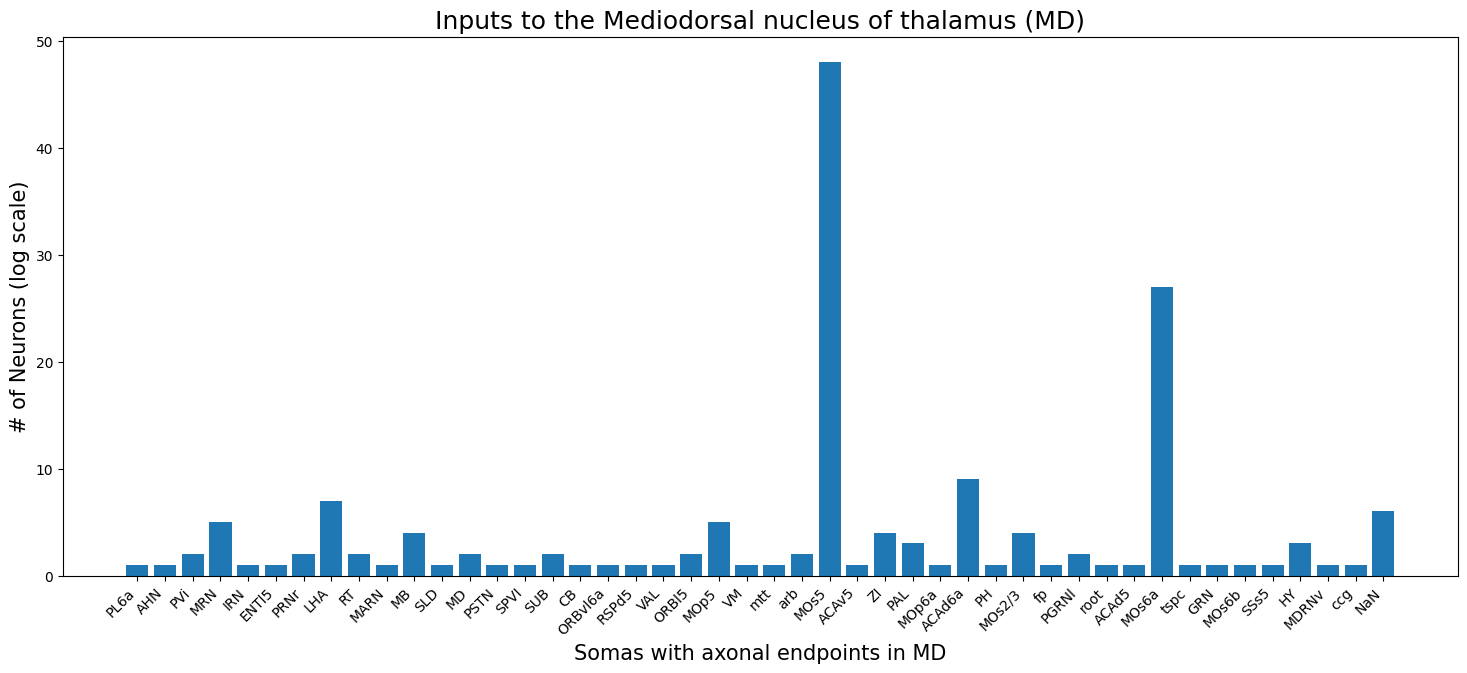

In [24]:
# Get brain region names
ccf_names = list()
for ccf_id in ccf_ids:
    acronym = get_ccf_property(ccf_atlas, ccf_id, "acronym")
    if type(acronym) is not str:
        get_ccf_property(ccf_id, "acronym", print_id=True)
    ccf_names.append("NaN" if type(acronym) is not str else acronym)

# Make plot
plt.figure(figsize=(18, 7))
plt.bar(ccf_names, cnts)
plt.xticks(rotation=45, ha='right')
#plt.yscale('log')

# Add titles and labels
plt.title("Inputs to the " + target_name + f" ({target_acronym})", fontsize=18)
plt.xlabel("Somas with axonal endpoints in " + target_acronym, fontsize=15)
plt.ylabel("# of Neurons (log scale)", fontsize=15)

# Show the plot
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


<font size='4'> Lastly, we will visualize the inputs to brain region by plotting all of these neurons by coloring it by the location of its soma (which ccf region it lies in).
    

In [25]:
ccf_ids_list = list()
for skel in skels_subset:
    ccf_ids_list.extend(
        get_ccf_ids(ccf_atlas,
            skel,
            compartment_type=1           
        )
    )
int_list = [int(i) for i in ccf_ids_list] #can't use this becausee it has very large numbers

#map this to a set of colors

unique_numbers = np.unique(int_list)
unique_colors = list()

mapper = {}
for i in unique_numbers:
    colorstr = "%06x" % random.randint(0, 0xFFFFFF)
    c  = int(colorstr, 16) + 0x200
    mapper[i] = c

colors_list = [c for c in map(mapper.get, int_list)]
print(colors_list)

[7373800, 4025455, 4025455, 5361974, 5361974, 15570207, 14369192, 15570207, 5407870, 5407870, 1091604, 15570207, 16311429, 2137289, 16524370, 13478977, 15570207, 13478977, 13478977, 8802080, 13478977, 2448723, 8802080, 13478977, 13478977, 13478977, 16311429, 13928657, 14369192, 13928657, 11696808, 14751863, 1715369, 1715369, 16594894, 10027510, 13993857, 1715369, 4356307, 15902902, 8442168, 8926723, 7501797, 1715369, 11126018, 15432065, 6575502, 11696808, 8802080, 13478977, 13478977, 15570207, 15570207, 15570207, 13478977, 13478977, 14751863, 2448723, 4781337, 14751863, 3005965, 1239745, 1091604, 15570207, 13478977, 13478977, 13478977, 6533254, 2540418, 15570207, 15570207, 15570207, 11151871, 13478977, 15570207, 7501797, 16746042, 16252714, 13478977, 3005965, 3778453, 2137289, 1715369, 4721531, 8566871, 15570207, 15570207, 15570207, 15570207, 13478977, 2448723, 13478977, 13478977, 1082172, 1082172, 13478977, 13478977, 2448723, 11696808, 2448723, 13478977, 1082172, 13478977, 13478977, 1

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<font size="4"><p><b>Exercise: </b> Visualize the cells colored by which region their soma lies in 3D with the CCF mesh. How is this different from the previous plot?
    
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<font size="4"><p><b>Exercise: </b> Redo this at a CCF depth of 5. How does this look different?
    
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
# Section 3: Analyzing Divergent Information Flow
    
<font size='4'> We've just looked at how inputs from different brain areas converge upon the Mediodorsal Nucleus of Thalamus (MD). However neurons are not exclusive in their projections, and a given cell will often have branching axonal fields targeting multiple different brain areas. We can learn about how information flows through the brain by looking at what input channels are shared between brain regions. Phrased another way, which brain areas are targeted by distinct collaterals of the same neuron?
    
<font size="4"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <strong>Question 2:</strong>  Where else do inputs to MD send their collaterals?  </font>


In [26]:
# Here we are setting up an alternative way to correspond CCF ids and region acronyms. We're establishing dictionaries to go between these properties.
# Some neurons have a small number of vertices with unrecognized IDs due to registration errors / differences in CCF versioning: so we're using a 
# default dict to set unrecognized IDs to a default value of NaN.
from collections import defaultdict
id_to_acronym = defaultdict(lambda: "NaN")
for ccf_id in list(ccf_atlas.lookup_df["id"]):
    id_to_acronym[ccf_id] = get_ccf_property(ccf_atlas, ccf_id, "acronym")

acronym_to_id = {acronym: ccf_id for ccf_id, acronym in id_to_acronym.items()}

## Pick a random Neuron from the set of Neurons that send information to MD
skel = skels_subset[55]

In [27]:
# Find the axon endpoints for our neuron and count how many terminate in each CCF region
axon_endpoints_ccf = get_ccf_ids(ccf_atlas,skel, compartment_type=2, vertex_type="end_points")
ids, cnts = np.unique(axon_endpoints_ccf, return_counts=True)


In [28]:
# Convert IDs to CCF acronyms for plotting purposes
endpoint_dataframe = pd.DataFrame({"CCF": [id_to_acronym[ccf_id] for ccf_id in ids], "Counts":cnts})


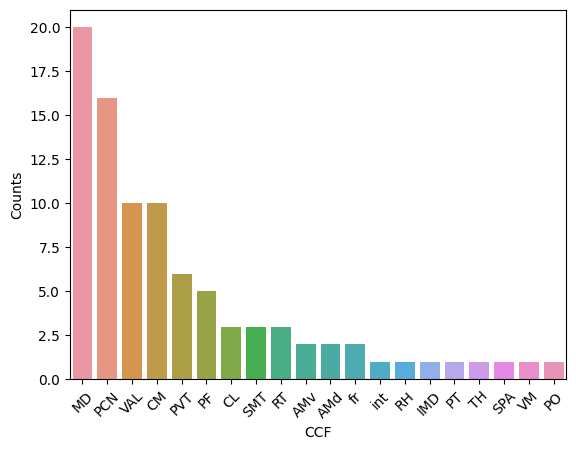

In [29]:
# Plot the axonal endpoints of our selected neuron
sns.barplot(endpoint_dataframe.sort_values("Counts", ascending=False).head(20), x="CCF", y="Counts")
plt.xticks(rotation=45);


In [31]:
# Plot the full neuronal morphology 
plot = k3d.plot()
plot_graphs([skel], plot)

# Add whole ccf mesh
ccf_mesh = get_whole_ccf_mesh()
mesh_plot = k3d.mesh(ccf_mesh.vertices*1000, ccf_mesh.faces, opacity=0.2, color=808080)
plot += mesh_plot

# Add MD mesh
region_mesh = get_region_ccf_mesh(362)
region_mesh_plot = k3d.mesh(region_mesh.vertices*1000, region_mesh.faces, opacity=0.2)
plot += region_mesh_plot

plot.display()

Output()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
# Section 4: Analyzing divergent information flow : Population Study
    
<font size='4'> We've now looked at a few of the diverse inputs to MD. How is this information integrated and distributed to the rest of the brain? Physiological experiments are best suited for interrogating how information is transformed across synapses. However morphological analysis can cue us into the output channels of the MD circuit. Do all MD neurons uniformly target the same brain structures, or is there diversity in their projection patterns? One way to formalize this question is with clustering analysis.
    
<font size="4"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <strong>Question 3:</strong> Are neuronal morphologies stereotyped, or are there distinct projection classes?


In [32]:
# imports
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [33]:
# Get neurons with somas in MD.
list_of_regions = ["MD"] # note that in your independent explorations, you can add more regions to this list to query
ccf_id_list = [acronym_to_id[region] for region in list_of_regions]
skels_subset = [skel for skel in skel_list if skel.vertex_properties['ccf'][skel.root] in ccf_id_list]
print(f"# Skeletons with somas in {list_of_regions}:", len(skels_subset))


# Skeletons with somas in ['MD']: 21


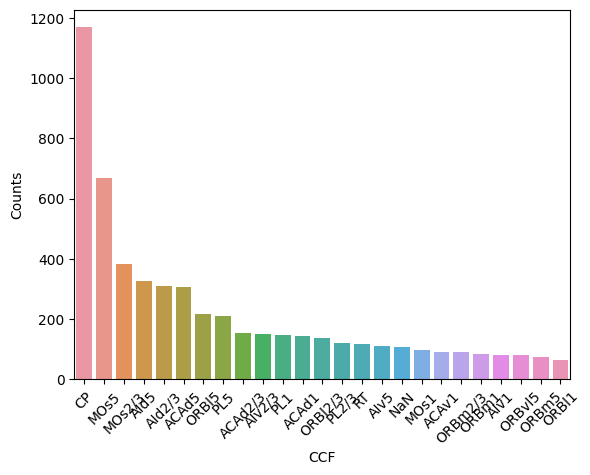

In [34]:
# First lets look at the projection targets of our population of neurons. We'll collect CCF endpoints:
axon_endpoints_ccf = list()
for skel in skels_subset:
    axon_endpoints_ccf.extend(get_ccf_ids(ccf_atlas, skel, compartment_type=2, vertex_type="end_points"))

axon_endpoints_ccf = [x for x in axon_endpoints_ccf if ~np.isnan(x)]

# Then we'll plot the total axonal endpoints of our population of neurons. To reduce visual clutter, we'll only plot the top 25 most targeted CCF structures.
n_structures_to_plot = 25
ids, cnts = np.unique(axon_endpoints_ccf, return_counts=True)
total_endpoints = pd.DataFrame({"CCF": [id_to_acronym[ccf_id] for ccf_id in ids], "Counts":cnts})
sns.barplot(
    total_endpoints.sort_values("Counts", ascending = False).head(n_structures_to_plot),
    x="CCF",
    y="Counts",
)
plt.xticks(rotation=45);

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<font size="4"><p><b>Question :</b> What are the most targeted brain regions by MD neurons? Does this change with the level of the CCF hierarchy that you're examining? 
    
Exercise: Plot the top 5 structures when axonal endpoints are queried at CCF depth 5.
    
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


<font size='4'> Next, let's try some simple clustering approaches to look at the diversity of our MD projections. We'll start by assembling a feature matrix where the rows are MD neurons and the columns are number of axonal endpoints in different CCF regions. You can imagine that other more exotic morphometric or topological features might have great descriptive power for distinguishing morphologies, but we'll keep things relatively simple for now.</font>
    

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


<font size='4'> Create a dictionary of each cell's axonal endpoints. We'll then convert this to a dataframe to allow for visualizations and clustering.</font>
    

In [35]:
# Collect axon endpoints from every cell in our subset
skel_dict = {}
for i, skel in enumerate(skels_subset):
    axon_endpoints_ccf = get_ccf_ids(ccf_atlas, skel, compartment_type=2, vertex_type="end_points")
    ids, cnts = np.unique(axon_endpoints_ccf, return_counts=True) # Count incidence of each terminal structure
    skel_dict[i] = dict(zip(ids,cnts)) # Bundle up CCF region IDs and counts for each cell
    


In [36]:
# Convert to dataframe, and remap column names from region IDs to region acronyms
df = pd.DataFrame.from_dict(skel_dict, orient='index').fillna(0)
df = df.loc[:, df.columns.isin(id_to_acronym.keys())]
df = df.rename(columns = id_to_acronym)
df = df.loc[:, df.columns != "NaN"] # remove any unrecognized CCF regions

In [37]:
# We can optionally trim our feature matrix to only include CCF regions that comprise a decent fraction of our total terminal endpoints across
# the population. Let's do so for now to reduce bloat in our visualizations, setting a threshold of at least 0.05% of the total endpoints.
trim_df = True
threshold = 0.0005

if trim_df:
    total_counts = df.sum(axis=0, numeric_only=True)
    cumsum = total_counts / sum(total_counts)
    keep_cols = cumsum > threshold
    df = df.loc[:,keep_cols]

<Axes: >

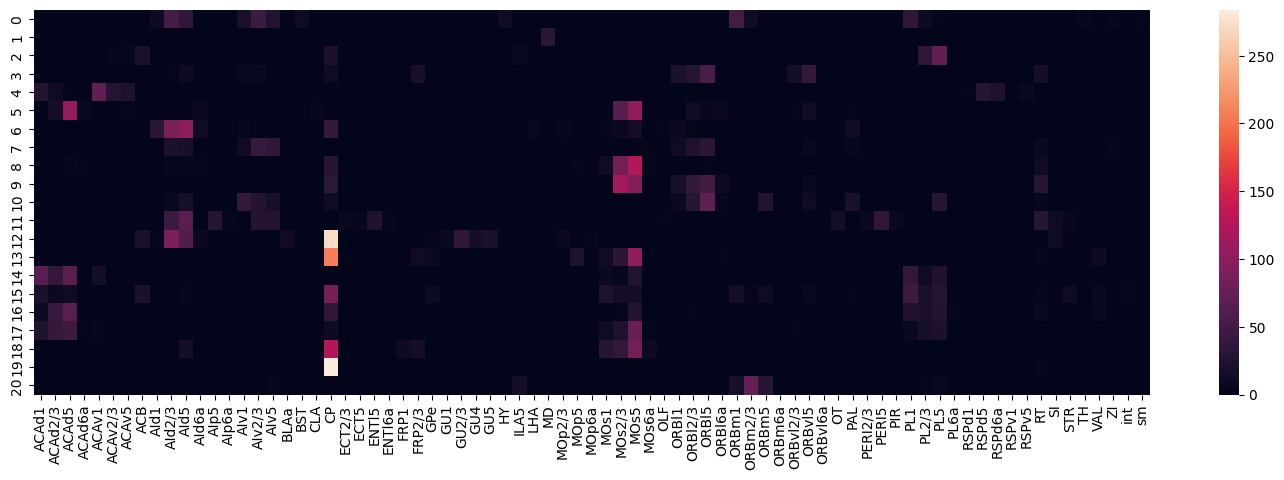

In [38]:
# Now lets visualize our feature matrix. We'll sort our columns to tidy up the visualization.
sorted_columns = sorted(df.columns)
df = df[sorted_columns] # Reorder the DataFrame based on sorted column names

plt.figure(figsize=(18,5))
sns.heatmap(df.sort_index())

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


<font size='4'> Now, we'll employ a general purpose clustering algorithim called K Means to automatically group neurons based on their projection properties. You can learn more here: https://scikit-learn.org/stable/modules/clustering.html#k-means. K Means requires specifying a number of output clusters a priori. We'll start with 3 clusters, and dig into more principled approaches for selecting this number later. </font>
    

In [39]:
# Initialize the KMeans model
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, n_init = "auto", random_state = 0)
kmeans.fit(df)

# Get the cluster labels
labels = kmeans.labels_

# We'll createa copy of our dataframe and add the cluster labels
df_clustered = df.copy()
df_clustered['cluster'] = labels

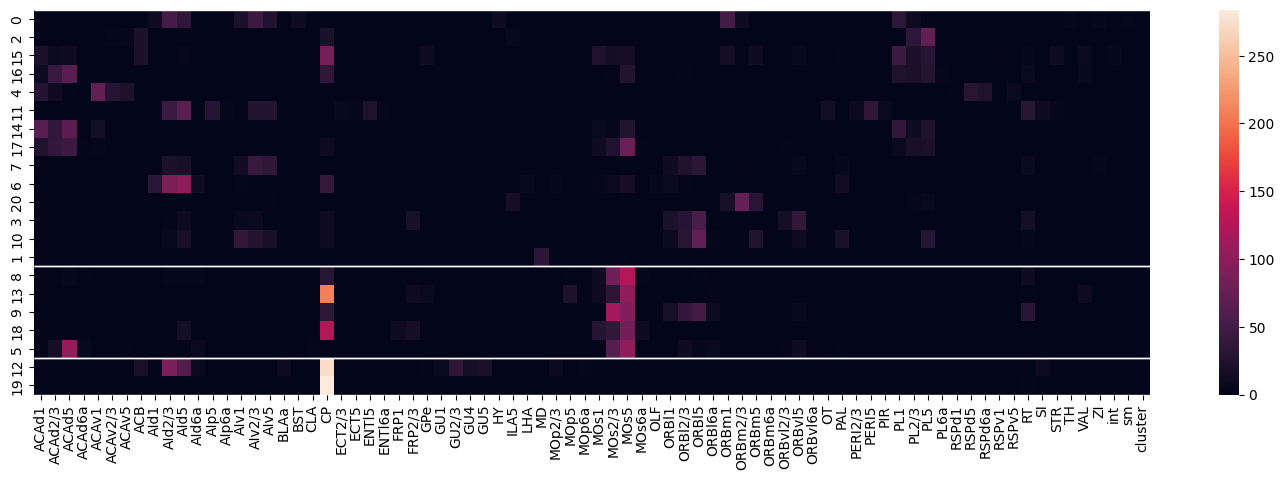

In [40]:
# Now lets visualize our clustering results.
df_clustered = df_clustered.sort_values("cluster") # sort by cluster label to organize plot

# Plot the heatmap
plt.figure(figsize=(18, 5))
sns.heatmap(df_clustered,  xticklabels=True)

# Outline clusters by adding lines
unique_clusters = df_clustered['cluster'].unique()
for cluster in unique_clusters:
    idx = np.where(df_clustered['cluster'] == cluster)[0]
    plt.hlines([min(idx), max(idx) + 1], *plt.xlim(), colors='white', linewidth=1)

In [41]:
# Let's also print the top structures targeted by each cluster.
top_regions = slice(0,3,1) # we'll specify that we want to look at the top 3 CCF regions
cluster_means = df_clustered.groupby("cluster").mean()
for i in range(len(cluster_means)):
    sorted_cluster_means = cluster_means.iloc[i,:].sort_values(ascending=False)
    output = ', '.join(f'({index}: {value:.{1}f})' for index, value in sorted_cluster_means[top_regions].items())
    print("Cluster #" + f"{i} top targets: " + output)

Cluster #0 top targets: (AId5: 17.8), (AId2/3: 15.4), (CP: 15.3)
Cluster #1 top targets: (MOs5: 101.4), (CP: 79.6), (MOs2/3: 66.2)
Cluster #2 top targets: (CP: 278.5), (AId2/3: 44.0), (AId5: 29.5)


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<font size="4"><p><b>Exercise: </b> Our feature matrix is a reduced representation of the original data. Let's check if our clustering makes sense by inspecting the morphologies belonging to a given cluster. Plot all of the neurons belonging to cluster 0 below.
    
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<font size="4"><p><b>Exercise:</b> K Means clustering requires specifying a number of K clusters to split your samples into a priori. However we rarely know in advance how many groups our data should be split into, and above we've chosen to specify 3 clusters somewhat arbitrarily. There isn't a definitive and absolute answer to the appropriate number of clusters to specify, but there are tools we can use to guide our selection of K. One tool is a metric called the silhouette score (https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py), which quantifies the proximity of points within clusters relative to points outside that cluster. Silhouette scores near 1 indicate clusters are very distinct, while values closer to 0 indicate points are close to the boundaries between clusters. 
    
Let's compare K Means Silhouette scores for different numbers of K. We've laid out some code to get you started below. Afterward, visualize and examine the clustering results for a few different values of K. Remember that Silhouette scores are only a tool to guide our selection of K, but are not the ultimate determinants of biological "truth".
</div>

In [42]:
## Guide

range_n_clusters = range(2, 15)
silhouette_avg = []

for k in range_n_clusters:
    # Code here!
    
    
    silhouette_avg.append(silhouette_score(df, cluster_labels))

# Plotting silhouette
plt.figure(figsize=(10, 4))
plt.plot(range_n_clusters, silhouette_avg, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Selection of K clusters')

NameError: name 'cluster_labels' is not defined